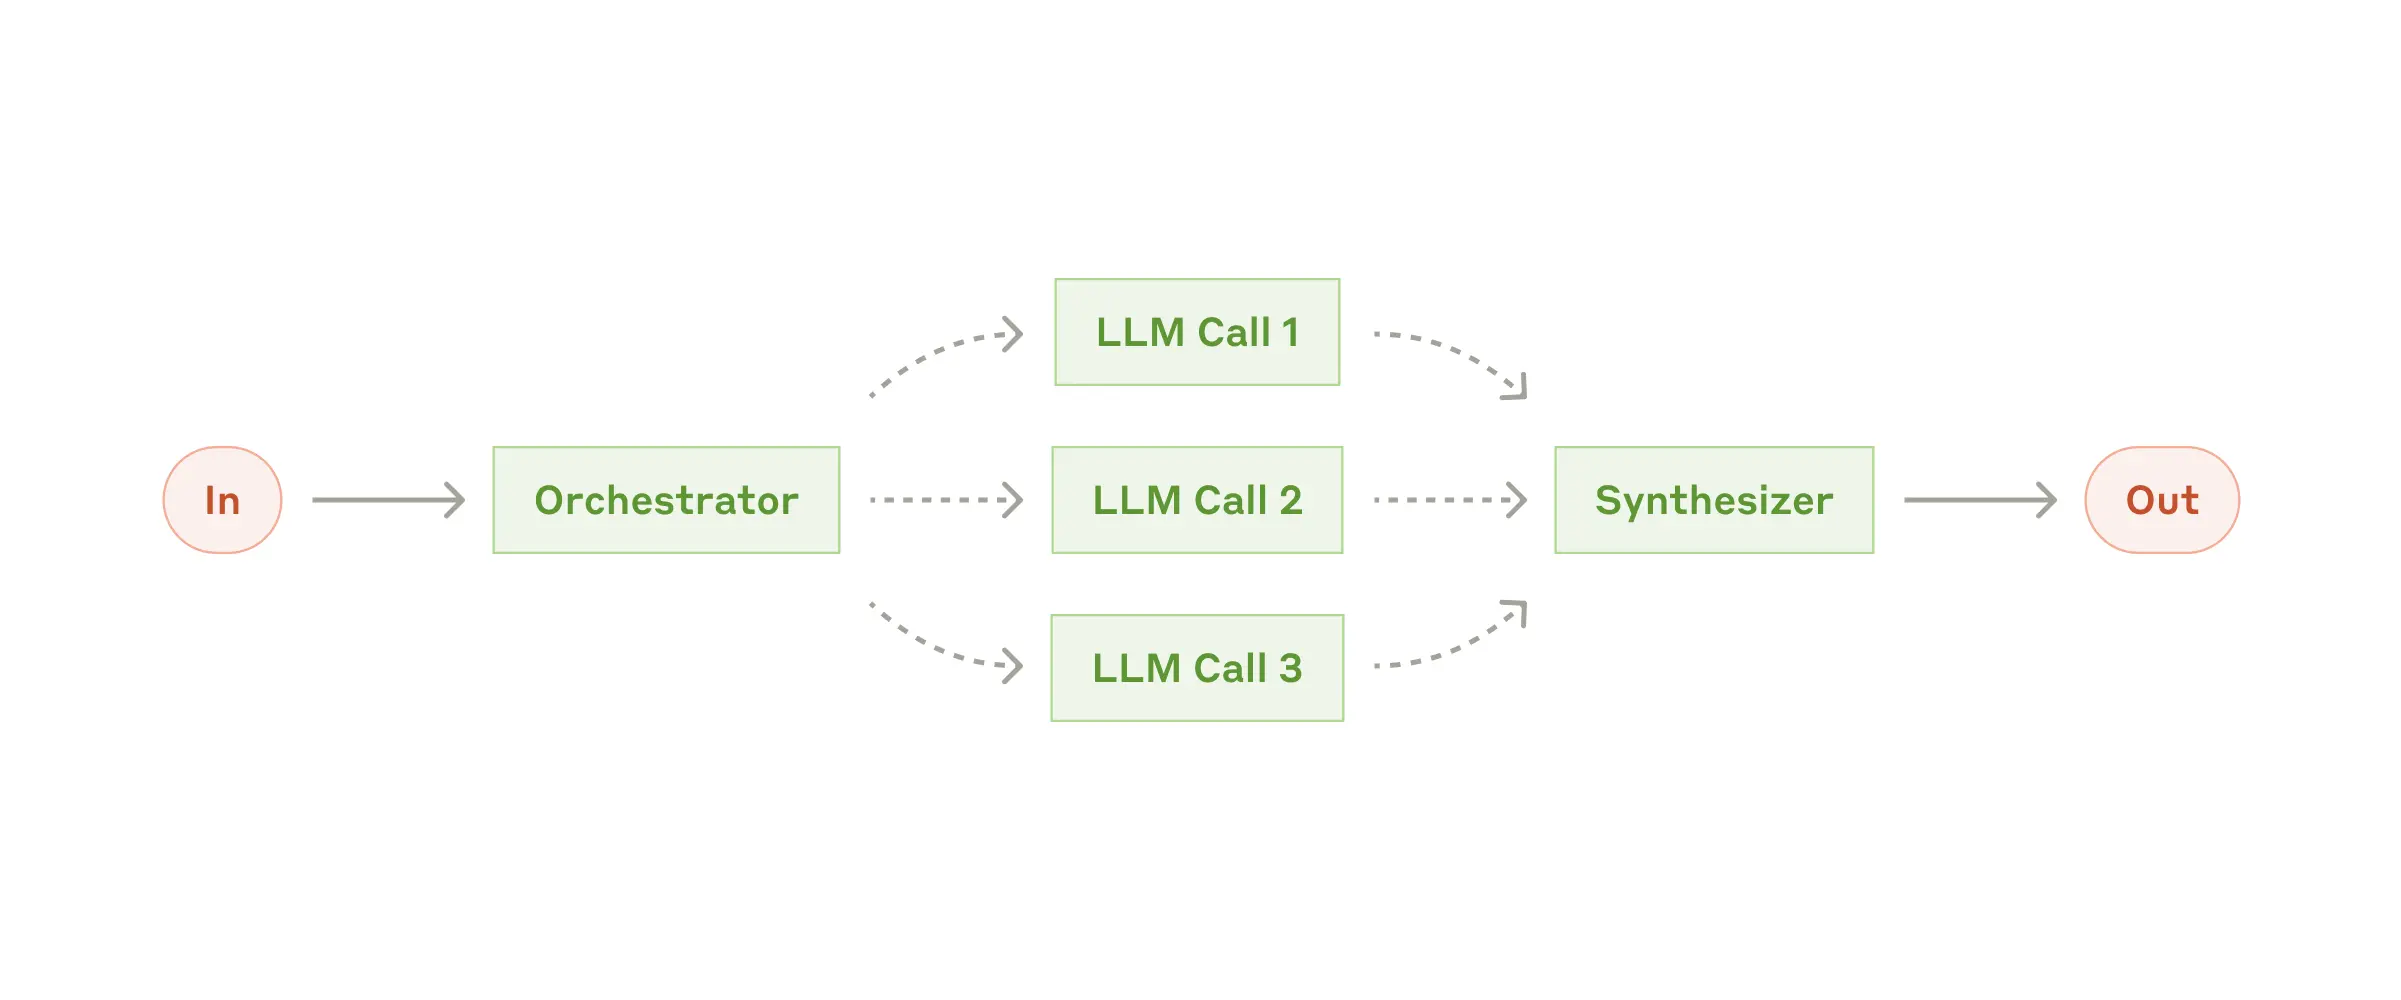

In [12]:
from langchain_core.messages import SystemMessage, HumanMessage

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Enter {var}: ")
    else:
        print(f"{var} already set")
        
_set_env("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY already set


In [7]:
llm.invoke("hi").content

'Hello! How can I assist you today?'

In [10]:
from typing import Annotated, List, TypedDict, operator
from pydantic import BaseModel, Field

class Section(BaseModel):
    name: str = Field(None, description="Name for this section of the report."),
    description: str = Field(None, description="Breif overview of the main topics and concepts to be convered in this section."),
    
class Report(BaseModel):
    sections: List[Section] = Field(None, description="Sections of the report.")
    
report_planner = llm.with_structured_output(Report)

/home/ksumit/miniconda3/envs/langchain-env/lib/python3.12/site-packages/pydantic/json_schema.py:2279: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default=None, description='Name for this section of the report.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)
/home/ksumit/miniconda3/envs/langchain-env/lib/python3.12/site-packages/pydantic/json_schema.py:2279: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=False, default=None, description='Breif overview of the main topics and concepts to be convered in this section.'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [11]:
# Graph State
class State(TypedDict):
    topic: str
    sections: List[Section]
    completed_sections: Annotated[list, operator.add] # all workers write to this in parallel
    final_report: str

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [34]:
# Nodes
def orchestrator(state: State):
    report_sections = report_planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    return {"sections": report_sections.sections}

In [35]:
from langgraph.constants import Send

def llm_call(state: WorkerState):
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}")
        ]
    )
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    completed_sections = state['completed_sections']
    report = "\n\n---\n\n".join(completed_sections)
    return {"final_report": report}

def assign_workers(state: State):
    return [Send("llm_call", {"section": s}) for s in state['sections']]

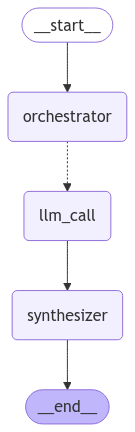

In [36]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Markdown
from IPython.display import display, Image


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [37]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Generate a very short report on virat kohli"})

In [ ]:
Markdown(state["final_report"])